# Create all the models we are going to use

Most of them aren't going to work particularly well. But, we are gonna build all the frameworks out, so as we update things, we can just rerun this notebook to get better performance.

In [1]:
# basic stuff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# sklearn for logreg, RF, GBT, and SVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# other stuff from sklearn we might need
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import resample # we have imbalanced classes
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# keras for the NN
from keras import Sequential, layers, models

# Stuff that I wrote
from utils.strings import TARGET, FEATURES, CAT_FEATURES, DATE
from utils.utilities import select_by_date

import pickle

Using TensorFlow backend.


# Load in the data

we also need to do some simple preprocessing (for now) before we can train all the models

In [2]:
inspecs = pd.read_csv('./data/inspec_scores.csv', parse_dates=[DATE])
inspecs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111854 entries, 0 to 111853
Data columns (total 29 columns):
camis                    111854 non-null int64
dba                      111854 non-null object
boro                     111854 non-null object
zipcode                  111854 non-null float64
cuisine_description      111854 non-null object
inspection_date          111854 non-null datetime64[ns]
action                   111854 non-null object
score                    111854 non-null float64
latitude                 111854 non-null float64
longitude                111854 non-null float64
grade                    111854 non-null object
violation_code           111854 non-null object
violation_description    111854 non-null object
critical_flag            111854 non-null object
inspection_type          111854 non-null object
critical                 111854 non-null int64
num_critical             111854 non-null int64
weekday                  111854 non-null object
tmax            

# Let's do some feature pre-processing

In [3]:
# encode the catagorical features. For some reason I couldn't just use the onehot.
# i needed to actually add new columns to the DF for each new feature

# enc = preprocessing.OneHotEncoder(sparse=False)
# for feat in CAT_FEATURES:
#     enc.fit(inspecs[feat].unique().reshape(-1, 1))
#     inspecs[f'{feat}_enc'] = enc.transform(inspecs[feat].values.reshape(-1, 1)).tolist()

for feat in CAT_FEATURES:
    try:
        new_df = pd.concat([new_df, pd.get_dummies(inspecs[feat])], axis=1)
    except NameError:
        new_df = pd.DataFrame(index=inspecs.index)
        new_df = pd.concat([new_df, pd.get_dummies(inspecs[feat])], axis=1)
#     new_df = new_df.drop([feat], axis=1, inplace=True)

In [4]:
new_df.head(5)

,A,B,C,Bronx,Brooklyn,Manhattan,Queens,Staten Island,10000.0,10001.0,...,11694.0,11697.0,12345.0,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [5]:
# merge the two frames together

FEATURES += new_df.columns.tolist()
inspecs = pd.concat([inspecs, new_df], axis=1)

In [6]:
inspecs[FEATURES].head(5)

,tmax,tmax_3d,time_since_last,past_critical,past_score,dsny_heat_score,dep_heat_score,dohmh_heat_score,is_chain,init_inspec,...,11694.0,11697.0,12345.0,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,92,79.000000,0.0,0.0,12.0,0.406452,0.117716,0.098959,0,1,...,0,0,0,0,0,0,0,1,0,0
1,73,72.333333,358.0,1.0,7.0,0.203028,0.074187,0.169137,0,0,...,0,0,0,1,0,0,0,0,0,0
2,73,56.333333,370.0,0.0,5.0,0.160208,0.027397,0.173178,0,0,...,0,0,0,0,0,0,0,1,0,0
3,77,76.333333,26.0,1.0,14.0,0.256666,0.399057,0.316888,0,0,...,0,0,0,0,0,0,0,0,1,0
4,67,59.000000,132.0,0.0,6.0,0.309046,0.031414,0.274051,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
inspecs.to_csv('./data/inspecs_encoded.csv', index=False)

# Class Imbalance

We know that we have really imbalanced classes. We will need to resample the two classes to make sure that we can train appropriately. Currently, I am both downsampling all the examples where there is a critical violation or upsampling all of the times when there isn't a critical violation.

We could use other fancier methods like SMOTE, but not right now.

In [7]:
# Previously we found that we have really imbalanced classes. Here we'll downsample the majority class to match
# the number of the minority class
# Separate majority and minority classes
df_majority = inspecs[inspecs[TARGET]==1]
df_minority = inspecs[inspecs[TARGET]==0]

# Downsample Majority Class
df_majority_dsampled = resample(df_majority, 
                                 replace=False, # sample without replacement
                                 n_samples=len(df_minority)) # to match minority class
 
# Combine minority class with downsampled majority class
df_dsampled = pd.concat([df_minority, df_majority_dsampled])
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority))    # to match majority class
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])    
    
    
# Display new class counts
print(inspecs[TARGET].value_counts()) # before
print(df_dsampled[TARGET].value_counts()) # downsample
print(df_upsampled[TARGET].value_counts()) # upsample

1    100369
0     11485
Name: critical, dtype: int64
1    11485
0    11485
Name: critical, dtype: int64
1    100369
0    100369
Name: critical, dtype: int64


In [ ]:
df_dsampled.to_csv('./data/inspecs_encoded_dsample.csv', index=False)
df_upsampled.to_csv('./data/inspecs_encoded_usample.csv', index=False)

In [8]:
#### START HERE FOR RESTARTS ####

# inspecs = pd.read_csv('./data/inspecs_encoded.csv', parse_dates=[DATE])
# df_upsampled = pd.read_csv('./data/inspecs_encoded_usample.csv', parse_dates=[DATE])

# Select the training and testing data

We are going to train on the balanced data, but we are going to test on the imbalanced data, because that is the what the world actully looks like. 


I've picked two months toward the middle of 2019, but it can be anything (in 2019).

In [9]:
train = select_by_date(df_upsampled, '2018-01-01', '2018-12-31')
train_imbalanced = select_by_date(inspecs, '2018-01-01', '2019-01-01')
test = select_by_date(inspecs, '2019-05-01', '2019-06-30')
test_balanced = select_by_date(df_upsampled, '2019-05-01', '2019-06-30')

In [10]:
print(train[TARGET].value_counts()) # train
print(test[TARGET].value_counts()) 

0    33407
1    31605
Name: critical, dtype: int64
1    6981
0     906
Name: critical, dtype: int64


In [11]:
df_major = test[test[TARGET]==1]
df_minor = test[test[TARGET]==0]

df_minor_up = resample(df_minor, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_major))

test_balanced = pd.concat([df_major, df_minor_up])

print(test_balanced[TARGET].value_counts()) # upsample

1    6981
0    6981
Name: critical, dtype: int64


In [12]:
print(train.shape)
print(test.shape)

(65012, 265)
(7887, 265)


# Build Models

We are gonna build a bunch of them. Mostly, because I am interested in their performance. We can also think about trying to combine models in some fancy-ish way. Like using a interpretable model to do feature ranking and then dumping those features into a less interpretable model (but better?) to make the actual predictions.

I am gonna builld a lot of models, because they are easy to do. If they were harder to actually impliment, then I would need to think harder about which models we actually care about... It would be some sort of a decision tree. It is both interpretable and will provide probabilities (what we actually care about) for the individual predictions.

# Logistic Regression

In [13]:
log_base = LogisticRegression(solver='lbfgs')
log_base.fit(train[FEATURES], train[TARGET])
predictions = log_base.predict(test[FEATURES])

with open('./models/logmodel.pkl', 'wb') as model:
    pickle.dump(log_base, model)

print(metrics.classification_report(test[TARGET], predictions))

              precision    recall  f1-score   support

           0       0.16      0.57      0.25       906
           1       0.92      0.62      0.74      6981

    accuracy                           0.61      7887
   macro avg       0.54      0.59      0.49      7887
weighted avg       0.83      0.61      0.68      7887



/home/boada/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Random Forest

In [14]:
RF_base = RandomForestClassifier()
RF_base.fit(train[FEATURES], train[TARGET])
predictions = RF_base.predict(test[FEATURES])

with open('./models/RFmodel.pkl', 'wb') as model:
    pickle.dump(RF_base, model)

print(metrics.classification_report(test[TARGET], predictions))

              precision    recall  f1-score   support

           0       0.41      0.09      0.15       906
           1       0.89      0.98      0.94      6981

    accuracy                           0.88      7887
   macro avg       0.65      0.54      0.54      7887
weighted avg       0.84      0.88      0.85      7887



<IPython.core.display.Javascript object>


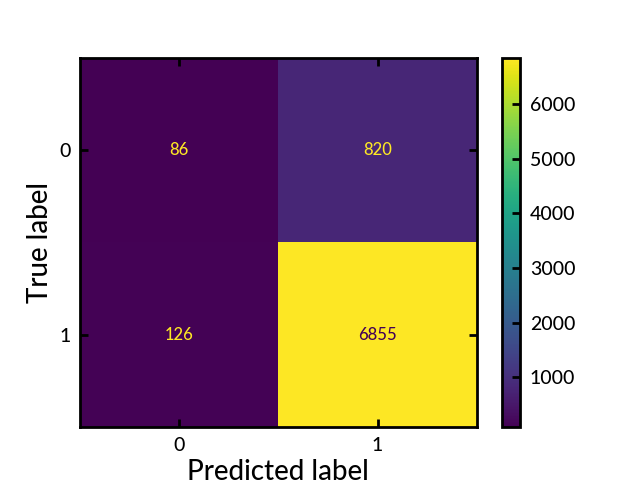

In [15]:
%matplotlib notebook
metrics.plot_confusion_matrix(RF_base, test[FEATURES], test[TARGET], values_format='d')

# Gradient Boosted Trees

In [16]:
GBT_base = GradientBoostingClassifier()
GBT_base.fit(train[FEATURES], train[TARGET])
predictions = GBT_base.predict(test[FEATURES])

with open('./models/GBTmodel.pkl', 'wb') as model:
    pickle.dump(GBT_base, model)

print(metrics.classification_report(test[TARGET], predictions))

              precision    recall  f1-score   support

           0       0.19      0.62      0.28       906
           1       0.93      0.65      0.76      6981

    accuracy                           0.64      7887
   macro avg       0.56      0.63      0.52      7887
weighted avg       0.84      0.64      0.71      7887



<IPython.core.display.Javascript object>


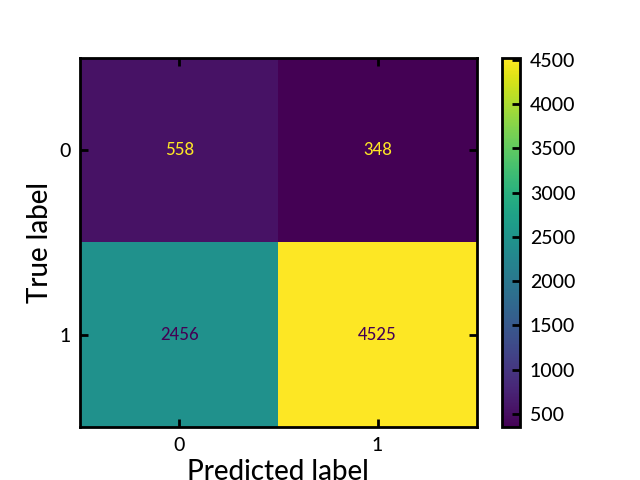

In [17]:
%matplotlib notebook
metrics.plot_confusion_matrix(GBT_base, test[FEATURES], test[TARGET], values_format='d')

# Adaboost

In [22]:
from sklearn.ensemble import AdaBoostClassifier
ada_base=AdaBoostClassifier(n_estimators=100, learning_rate=1)
ada_base.fit(train[FEATURES], train[TARGET])
predictions = ada_base.predict(test[FEATURES])

with open('./models/AdaBmodel.pkl', 'wb') as model:
    pickle.dump(ada_base, model)

print(metrics.classification_report(test[TARGET], predictions))

              precision    recall  f1-score   support

           0       0.18      0.62      0.27       906
           1       0.93      0.63      0.75      6981

    accuracy                           0.62      7887
   macro avg       0.55      0.62      0.51      7887
weighted avg       0.84      0.62      0.69      7887



<IPython.core.display.Javascript object>


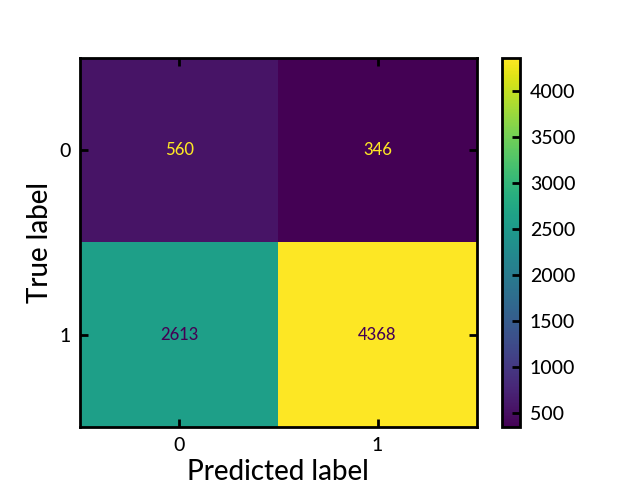

In [23]:
%matplotlib notebook
metrics.plot_confusion_matrix(ada_base, test[FEATURES], test[TARGET], values_format='d')

# XGBoost


In [24]:
import xgboost as xgb
xgb_base = xgb.XGBClassifier()
xgb_base.fit(train[FEATURES], train[TARGET])
predictions = xgb_base.predict(test[FEATURES])

with open('./models/XGBmodel.pkl', 'wb') as model:
    pickle.dump(xgb_base, model)

print(metrics.classification_report(test[TARGET], predictions))


              precision    recall  f1-score   support

           0       0.19      0.62      0.29       906
           1       0.93      0.65      0.76      6981

    accuracy                           0.65      7887
   macro avg       0.56      0.63      0.53      7887
weighted avg       0.84      0.65      0.71      7887



<IPython.core.display.Javascript object>


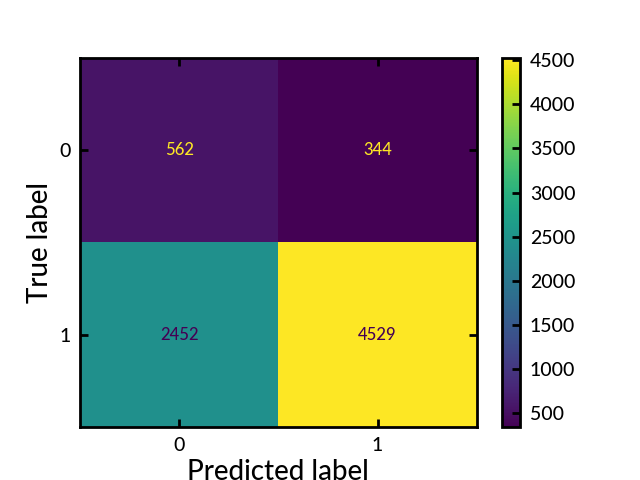

In [25]:
metrics.plot_confusion_matrix(xgb_base, test[FEATURES], test[TARGET], values_format='d')

# Simple Neural Network

Using Keras

In [ ]:
from keras import Sequential, layers, models

input_shape = train[FEATURES].shape[1]

# Instantiation = Initialising the neural network object,it's a sequential model
model = models.Sequential()
# First hidden layer
model.add(layers.Dense(activation="relu", input_dim=input_shape, units=100, kernel_initializer="uniform"))
# Second hidden 
model.add(layers.Dense(activation="relu", units=50, kernel_initializer="uniform"))
# Add the Output layer
model.add(layers.Dense(1, activation="sigmoid", kernel_initializer="uniform"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NN_base = model.fit(train[FEATURES],train[TARGET], epochs=50, batch_size=256, validation_split=0.2, verbose=3)

with open('./models/NNmodel.pkl', 'wb') as model:
    pickle.dump(NN_base.model, model)

predictions = NN_base.model.predict_classes(test_balanced[FEATURES])
print(metrics.classification_report(test_balanced[TARGET], predictions))

# Feature Ranking

Let's see if we can get some better performance by removing low importance features.

In [26]:
idx = np.argsort(RF_base.feature_importances_)[::-1]
for f, i in zip(np.asarray(FEATURES)[idx], RF_base.feature_importances_[idx]):
    if i > 0.001:
        print(f'{f}\t\t{i:.5f}')

time_since_last		0.12179
dsny_heat_score		0.09273
dep_heat_score		0.09260
dohmh_heat_score		0.09104
tmax_3d		0.07587
tmax		0.07101
past_score		0.06622
is_chain		0.02000
Wednesday		0.01138
Thursday		0.01098
Tuesday		0.01096
Manhattan		0.01095
Monday		0.01013
Brooklyn		0.00971
past_critical		0.00953
Queens		0.00929
Friday		0.00784
Bronx		0.00696
B		0.00533
10019.0		0.00487
10003.0		0.00469
10036.0		0.00450
C		0.00427
10013.0		0.00422
A		0.00417
Saturday		0.00414
Staten Island		0.00390
10001.0		0.00386
10022.0		0.00375
10014.0		0.00355
10017.0		0.00347
10016.0		0.00345
10011.0		0.00340
10012.0		0.00324
10018.0		0.00323
11201.0		0.00321
11217.0		0.00319
11215.0		0.00316
10002.0		0.00311
11220.0		0.00309
11372.0		0.00298
11101.0		0.00260
11354.0		0.00258
11368.0		0.00257
11385.0		0.00256
init_inspec		0.00251
10010.0		0.00244
10009.0		0.00243
10023.0		0.00236
11373.0		0.00233
11226.0		0.00231
11432.0		0.00230
10025.0		0.00227
11238.0		0.00226
11103.0		0.00225
11211.0		0.00224
11209.0		0.0021

So according to the RF, the first 26 features are "important" and then it's all the zip codes... Let's use the first 26

In [27]:
new_FEATURES = np.asarray(FEATURES)[idx][:27].tolist()
print(new_FEATURES)

['time_since_last', 'dsny_heat_score', 'dep_heat_score', 'dohmh_heat_score', 'tmax_3d', 'tmax', 'past_score', 'is_chain', 'Wednesday', 'Thursday', 'Tuesday', 'Manhattan', 'Monday', 'Brooklyn', 'past_critical', 'Queens', 'Friday', 'Bronx', 'B', '10019.0', '10003.0', '10036.0', 'C', '10013.0', 'A', 'Saturday', 'Staten Island']


In [28]:
# There is some issue with just using them... AH!
# I remember... the column headings are floats. So we have to convert them from strings..
# seems wonky, but it works... 
nf = []
for f in new_FEATURES:
    try:
        nf.append(float(f))
    except ValueError:
        nf.append(f)

In [29]:
nf

['time_since_last',
 'dsny_heat_score',
 'dep_heat_score',
 'dohmh_heat_score',
 'tmax_3d',
 'tmax',
 'past_score',
 'is_chain',
 'Wednesday',
 'Thursday',
 'Tuesday',
 'Manhattan',
 'Monday',
 'Brooklyn',
 'past_critical',
 'Queens',
 'Friday',
 'Bronx',
 'B',
 10019.0,
 10003.0,
 10036.0,
 'C',
 10013.0,
 'A',
 'Saturday',
 'Staten Island']

In [30]:
# Look at the RF again... 

RF_base.fit(train[nf], train[TARGET])
predictions = RF_base.predict(test[nf])

print(metrics.classification_report(test[TARGET], predictions))


### So removing the extra features doesn't acutally help it... Let's look at another one... 

              precision    recall  f1-score   support

           0       0.38      0.08      0.13       906
           1       0.89      0.98      0.94      6981

    accuracy                           0.88      7887
   macro avg       0.63      0.53      0.53      7887
weighted avg       0.83      0.88      0.84      7887



In [31]:
xgb_base.fit(train[nf], train[TARGET])
predictions = xgb_base.predict(test[nf])

print(metrics.classification_report(test[TARGET], predictions))

              precision    recall  f1-score   support

           0       0.18      0.64      0.29       906
           1       0.93      0.63      0.75      6981

    accuracy                           0.63      7887
   macro avg       0.56      0.63      0.52      7887
weighted avg       0.84      0.63      0.70      7887



# Hyperparameter Tuning

Gonna use a search!

In [32]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


### Here's a bunch of code I copied from the net ###

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=200, num=20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 500, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


RF_tuned = RandomizedSearchCV(estimator=RF_base, 
                               param_distributions=random_grid, 
                               n_iter=10, 
                               cv=3, 
                               verbose=2, 
                               n_jobs =-1)

RF_tuned.fit(train[FEATURES], train[TARGET])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [33]:
RF_tuned.best_params_

{'n_estimators': 30,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 108,
 'bootstrap': True}

In [34]:
RF_tuned.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 108,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 30,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [36]:
predictions = RF_tuned.best_estimator_.predict(test[FEATURES])

print(metrics.classification_report(test[TARGET], predictions))

              precision    recall  f1-score   support

           0       0.38      0.10      0.16       906
           1       0.89      0.98      0.93      6981

    accuracy                           0.88      7887
   macro avg       0.64      0.54      0.55      7887
weighted avg       0.83      0.88      0.85      7887



<IPython.core.display.Javascript object>


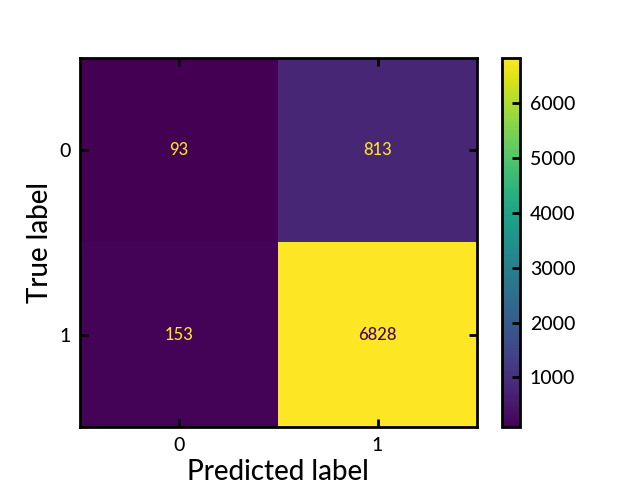

In [37]:
metrics.plot_confusion_matrix(RF_tuned.best_estimator_, test[FEATURES], test[TARGET], values_format='d')

In [ ]:
# adaboost doesn't have that many parameters

param_grid_ada = {'n_estimators': [30, 50, 70,100, 150],
                'learning_rate': [1.0, 0.5, 0.1]}

grid_ada_res = GridSearchCV(estimator=ada_base,
                     param_grid=param_grid_ada,
                     cv=3,
                     verbose=2,
                         n_jobs=-1)
grid_ada_res.fit(train[FEATURES], train[TARGET])

In [ ]:
grid_ada_res.best_params_

In [ ]:
grid_ada_res.best_score_

In [ ]:
predictions = grid_ada_res.best_estimator_.predict(test[FEATURES])

print(metrics.classification_report(test[TARGET], predictions))

In [ ]:
metrics.plot_confusion_matrix(grid_ada_res.best_estimator_, test[FEATURES], test[TARGET], values_format='d')

In [ ]:
ada_base=AdaBoostClassifier(learning_rate=grid_ada_res.best_params_['learning_rate'],
                            n_estimators=grid_ada_res.best_params_['n_estimators'])
ada_base.fit(train[FEATURES], train[TARGET])
predictions = ada_base.predict(test2[FEATURES])

print(metrics.classification_report(test2[TARGET], predictions))

In [38]:
import xgboost as xgb

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=200, num=20)]
# Maximum number of levels in tree
max_depth = [x for x in np.arange(1, 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_child_weight = [0, 1, 2, 3]
# Minimum number of samples required at each leaf node
learning_rate = [x for x in np.linspace(0.1, 1, num=5)]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid

param_grid_xgb= {
    "learning_rate": [0.3,0.5,0.7],
    'max_depth': [5,6,7],
    'min_child_weight': [0,1,3],
    'n_estimators': [10,100],
}


random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'learning_rate': learning_rate,
}

In [39]:
random_grid

{'n_estimators': [10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200],
 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
 'min_child_weight': [0, 1, 2, 3],
 'learning_rate': [0.1, 0.325, 0.55, 0.775, 1.0]}

In [40]:
grid_xgb = RandomizedSearchCV(estimator=xgb.XGBClassifier(),
                               param_distributions=random_grid, 
                               n_iter=10, 
                               cv=3, 
                               verbose=2, 
                               n_jobs =-1)

grid_xgb.fit(train[FEATURES], train[TARGET])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.325, 0.55,
                                          

In [41]:
grid_xgb.best_params_

{'n_estimators': 130,
 'min_child_weight': 2,
 'max_depth': 10,
 'learning_rate': 0.325}

In [42]:
grid_xgb.best_score_

0.8998331205932324

In [43]:
predictions = grid_xgb.best_estimator_.predict(test[FEATURES])

In [44]:
print(metrics.classification_report(test[TARGET], predictions))

              precision    recall  f1-score   support

           0       0.22      0.24      0.23       906
           1       0.90      0.89      0.89      6981

    accuracy                           0.81      7887
   macro avg       0.56      0.56      0.56      7887
weighted avg       0.82      0.81      0.82      7887



<IPython.core.display.Javascript object>


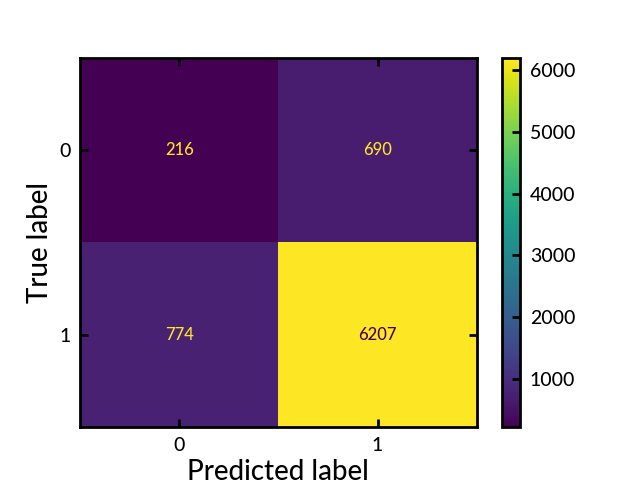

In [45]:
metrics.plot_confusion_matrix(grid_xgb.best_estimator_, test[FEATURES], test[TARGET], values_format='d')

In [ ]:
clf = grid_xgb.best_estimator_

idx = np.argsort(clf.feature_importances_)[::-1]

for f, i in zip(np.asarray(FEATURES)[idx], clf.feature_importances_[idx]):
        print(f, i)

In [ ]:
# from sklearn.feature_selection import RFE

# clf = GradientBoostingClassifier(n_estimators=100)
# rfe = RFE(estimator=clf, n_features_to_select=None, step=1)
# rfe.fit(train[FEATURES], train[TARGET])
# print(rfe.support_)
# print(rfe.ranking_)

# new_FEATURES = np.array(FEATURES)[rfe.support_]
# new_FEATURES = new_FEATURES.tolist()

# clf = GradientBoostingClassifier(n_estimators=100)
# clf = clf.fit(train[nf], train[TARGET])
# predictions = clf.predict(test[nf])

# print(metrics.classification_report(test[TARGET], predictions))

# nf = []
# for f in new_FEATURES:
#     try:
#         nf.append(float(f))
#     except ValueError:
#         nf.append(f)

# # Create the RFE object and rank each pixel
# svc = SVC(kernel="linear", C=1)
# rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
# rfe.fit(train[FEATURES], train[TARGET])

# print(rfe.support_)
# print(rfe.ranking_)

# FEATURES[idx]

# from tpot import TPOTClassifier

# tpot = TPOTClassifier(verbosity=2, max_time_mins=5, max_eval_time_mins=0.04, population_size=10)

# tpot.fit(train[FEATURES], train[TARGET])
# tpot.score(test[FEATURES], test[TARGET])
# predictions = tpot.predict(test[FEATURES])
# print(metrics.classification_report(test[TARGET], predictions))

# y_pred_proba = tpot.predict_proba(test[FEATURES])[::,1]
# fpr, tpr, _ = metrics.roc_curve(test[TARGET],  y_pred_proba)
# auc = metrics.roc_auc_score(test[TARGET], y_pred_proba)
# plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# plt.legend(loc=4)

# def plt_hist(history):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(len(acc))
#     plt.plot(epochs, acc, 'bo', label='Training acc')
#     plt.plot(epochs, val_acc, 'b', label='Validation acc')
#     plt.title('Training and validation accuracy')
#     plt.legend()
#     plt.figure()
#     plt.plot(epochs, loss, 'bo', label='Training loss')
#     plt.plot(epochs, val_loss, 'b', label='Validation loss')
#     plt.title('Training and validation loss')
#     plt.legend()

# plt_hist(NN_base)

# predictions = model.predict_classes(test2[FEATURES])
# print(metrics.classification_report(test2[TARGET], predictions))

# model.summary()